In [2]:
# Calculate miu_a, miu_s through x*h=y, x = f(miu_a,miu_s);no deconvolution
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg
import scipy as scipy
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc

In [39]:
## Read data from txt
with open('Oil_0719\\01.txt','r',encoding='utf-8') as f:
    content = f.read()
flag = 0
for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
    if (content[index] == '\n') and (flag != 8):
        flag = flag + 1
    elif (content[index] == '\n') and (flag == 8):
        break
    else:
        continue

# print(content[index+7:len(content)])
data_ns = pd.read_csv(StringIO(content[index+7:len(content)])) ## Read data of time and wavelengths
img_nm_ns = np.array(data_ns)    ## Transform to numpy array           

In [40]:
data_ns

,5.370049e+002,5.374453e+002,5.378857e+002,5.383261e+002,5.387665e+002,5.392068e+002,5.396472e+002,5.400876e+002,5.405280e+002,5.409684e+002,...,8.144450e+002,8.148853e+002,8.153257e+002,8.157661e+002,8.162065e+002,8.166469e+002,8.170873e+002,8.175276e+002,8.179680e+002,8.184084e+002
0.109053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.218119,0,0,0,2,0,1,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
0.327197,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
0.436288,0,1,0,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.545392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52.959260,0,1,0,1,0,0,1,0,0,0,...,1,0,2,0,0,1,1,0,1,0
53.071920,0,0,1,0,2,1,1,2,1,1,...,1,1,0,0,0,0,1,0,1,0
53.184590,0,1,1,1,0,1,0,1,0,0,...,0,1,1,0,0,1,1,0,0,0
53.297250,0,0,1,0,1,2,2,1,1,0,...,0,0,0,0,1,0,1,0,1,0


In [41]:
time_total, wavelength_total = data_ns.shape
array_ns = np.array(data_ns)

In [42]:
fluorescene = np.zeros((wavelength_total,))
for i in range(wavelength_total):
    fluorescene[i] = np.sum(array_ns[:,i],0)


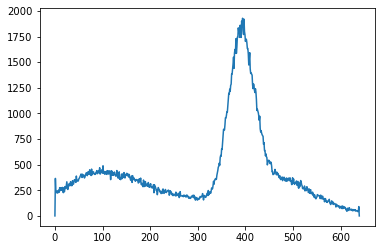

In [43]:
plt.plot(fluorescene)
plt.show()

In [53]:
max_index = np.argmax(fluorescene)
print(max_index)
print(data_ns.columns[max_index])

394
7.105151e+002


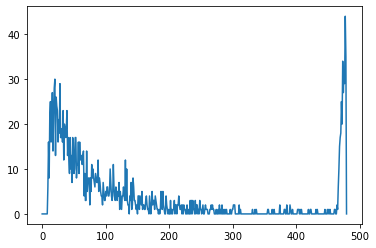

In [54]:
plt.plot(array_ns[:,max_index])
plt.show()

In [58]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()
        
        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 8):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 8):
                break
            else:
                continue

        # print(content[index+7:len(content)])
        data_ns = pd.read_csv(StringIO(content[index+7:len(content)])) ## Read data of time and wavelengths
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        fluorescene = np.zeros((wavelength_total,))
        for i in range(wavelength_total):
            fluorescene[i] = np.sum(self.data_array[:,i],0)
        max_index = np.argmax(fluorescene)
        self.curve = self.data_array[:,max_index]
        
        return self.curve
    
    def smooth(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        sigma=1
        x = np.linspace(-1, 1, 20)
        x0 = 0
        gauss = 1/(2*np.pi*sigma**2) * np.exp(- ((x -x0)**2 / (2 * sigma**2)))
        self.curve[int(0.95*time_total):time_total-1] = 0
            
        self.y_smooth = np.convolve(self.curve, gauss, mode='same')
        return self.y_smooth
    
    def cut(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        argmax = np.argmax(self.y_smooth)
        y_cut = np.zeros((time_total,))
        y_cut[0:time_total - argmax] = self.y_smooth[argmax:time_total]
        self.y_cut = y_cut
        return argmax, y_cut
    
    def interpo(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        max_fluo = np.max(self.y_smooth)
        
        time_fluo = np.zeros((2,))
        time_index = self.data_frame.index
        ##插值-----------------------------
        strech_times = 3
        x=np.linspace(0,time_total-1,time_total)
        xnew=np.linspace(0,time_total-1,time_total*strech_times)
       
        f1=scipy.interpolate.interp1d(x,self.y_smooth,kind='cubic')
        f2=scipy.interpolate.interp1d(x,time_index,kind='cubic')
        #f是一个函数，用这个函数就可以找插值点的函数值了：
        ynew=f1(xnew)
        timenew = f2(xnew)
        self.xnew = xnew
        self.ynew = ynew
        self.timenew = timenew
        ##---------------------------
        return xnew,ynew,timenew
    
    def fluo_time(self, xnew,ynew,timenew,thre):
        max_fluo = np.max(self.y_smooth)
        time_fluo = np.zeros((3,))
        threshold0 = thre
        j=0 
        k=0
        timepeak = np.argmax(ynew)
        for i in range(len(timenew)):
            if((abs(ynew[i]-threshold0*max_fluo)<=0.01*max_fluo)and(i<=timepeak)):
                time_fluo[0] = time_fluo[0] + i
                j=j+1
            elif((abs(ynew[i]-threshold0*max_fluo)<=0.01*max_fluo)and(i>timepeak)):
                time_fluo[1] = time_fluo[1] + i
                k=k+1
        time_fluo[1] = timenew[int(time_fluo[1]/k)]
        time_fluo[0] = timenew[np.argmax(ynew)] 
        time_fluo[2] =  time_fluo[1] -  time_fluo[0]
        
#              
        return time_fluo
    
    def fluoseries(self, xnew,ynew,timenew):
        N = 9
        thre = np.linspace(0.2,0.8,N)
        fluo = np.zeros((N,3))
        for i in range(N):
            fluo[i] = self.fluo_time(xnew,ynew,timenew,thre[i])
            fluo[i,2] = -fluo[i,2]/math.log(thre[i])
        return fluo
            
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [59]:
def g(i):
    if (i<=5):
        return 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\'+'0'+str(2*i-1)
    else :
        return 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\'+str(2*i-1)
dict1 = {i: g(i) +'.txt' for i in range(1, 9)}
dict1[0] = 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\A.txt'
dict1[-1] = 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\Ref.txt'

In [60]:
dict1

{1: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\01.txt',
 2: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\03.txt',
 3: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\05.txt',
 4: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\07.txt',
 5: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\09.txt',
 6: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\11.txt',
 7: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\13.txt',
 8: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\15.txt',
 0: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\A.txt',
 -1: 'D:\\files2\\Nagoya\\python\\oliver oil\\Oil_0719\\Ref.txt'}

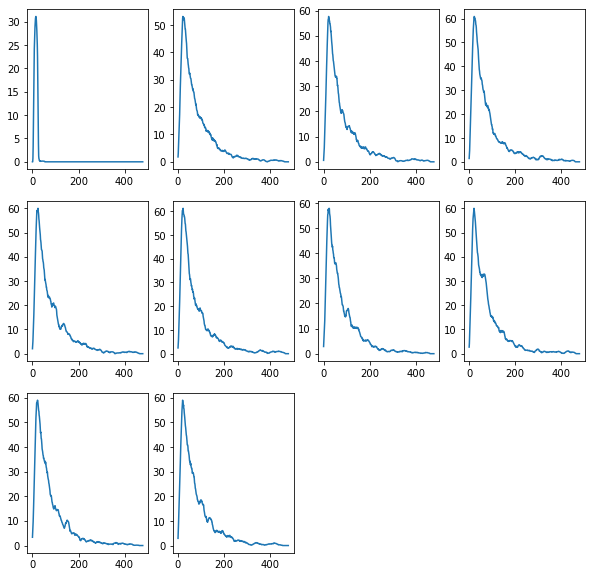

In [64]:
N = 10
scat = [None]*N
n_time_labels = 480
data_480multi9 = np.zeros((N, n_time_labels), dtype = float)
data_smooth1 = np.zeros((N, n_time_labels))
time_fluo = np.zeros((N,3))
a = np.zeros((N,9,3))
argmax = np.zeros((N,))
y_cut = np.zeros((N,n_time_labels))
for i in range(0, N):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()
    data_smooth1[i] = scat[i].smooth()
    argmax[i], y_cut[i] = scat[i].cut()
    
time_index = scat[0].return_dataframe().index

plt.figure(figsize = (10,10))
for i in range(0, N):
    plt.subplot(3,4,i+1)
    plt.plot(data_smooth1[i])
    
plt.show()

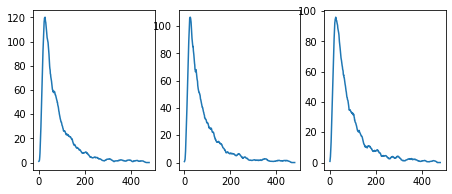

In [100]:
dict2={0:'a01.txt',1:'a07.txt',2:'a13.txt'}
N = 3
scat = [None]*N
n_time_labels = 480
data_480multi9 = np.zeros((N, n_time_labels), dtype = float)
data_smooth2 = np.zeros((N, n_time_labels))
time_fluo = np.zeros((N,3))
a = np.zeros((N,9,3))
argmax2 = np.zeros((N,))
y_cut2 = np.zeros((N,n_time_labels))
for i in range(0, N):
    scat[i] = process_hyperspec(dict2[i], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()
    data_smooth2[i] = scat[i].smooth()
    argmax2[i], y_cut2[i] = scat[i].cut()
    
time_index = scat[0].return_dataframe().index
plt.figure(figsize = (10,10))
for i in range(0, N):
    plt.subplot(3,4,i+1)
    plt.plot(data_smooth2[i])
    
plt.show()

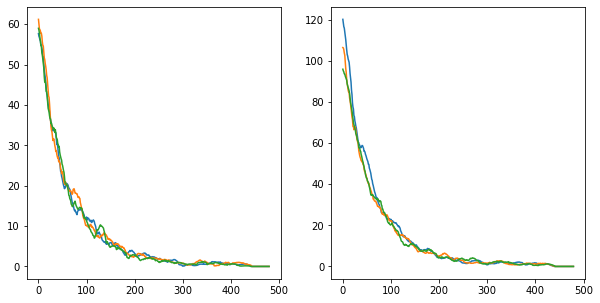

In [34]:

plt.figure(figsize = (10,5))
line1 = [None]*10
line2 = [None]*3
I = [2,5,8]
plt.subplot(1,2,1)
for i in I:
    #plt.plot(scipy.signal.savgol_filter(data_480multi9[i,:],53,3))
    line1[i], = plt.plot(y_cut[i,:])
##plt.legend([line[0], line[1],line[2]], ['a01', 'a07','a13'])
plt.subplot(1,2,2)
for i in range(3):
    #plt.plot(scipy.signal.savgol_filter(data_480multi9[i,:],53,3))
    line2[i], = plt.plot(y_cut2[i,:])
plt.show()

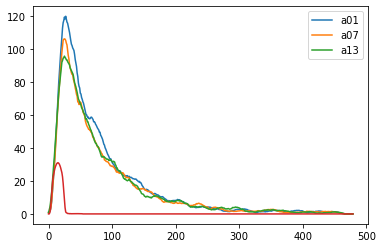

In [116]:
line4 = [None]*N
for i in range(3):
    line4[i], = plt.plot(data_smooth2[i])
    
plt.plot(data_smooth1[0])
plt.legend([line4[0], line4[1],line4[2]], ['a01', 'a07','a13'])
plt.show()

In [155]:
# we want to know h ; x*h = y
def deconv(x,y_959): 
    # prepare a laguerre series 
    #------------------------------------------------------------------------------
    M = 50
    a = 0.001
    LENGTH = 480
    L = np.zeros((M+1, LENGTH))
    # TIME = np.arange(LENGTH)
    alfa = 8
    for t in range(LENGTH):
        L[0, t] = 1
        L[1, t] = 1 + alfa - t*a

    for j in range(2,M+1):
        for t in range(LENGTH):
            L[j,t] = ((2*j - 1 + alfa - t*a)*L[j-1,t] - (j - 1 + alfa)*L[j-2,t])/(j)
    #-------------------------------------------------------------------------------
    
    

    Ln = M + 1
    v = np.zeros((959, Ln))
    for i in range(Ln):
        v[:, i] = np.convolve(x, L[i,:])


    c = np.linalg.lstsq(v, y_959, rcond=None)[0]

    # h = np.polynomial.laguerre.Laguerre(coef = c, domain = [0,LENGTH-1], window = [0,(LENGTH-1)*a])(t)

    # print(c)
    h = c.dot(L)
    return h

In [156]:
y_959 = np.zeros((N,959))
h = np.zeros((N,480))
x = data_smooth1[0]
for i in range(N):
    y_959[i,0:480] = data_smooth2[i]
    h[i] = deconv(x,y_959[i])

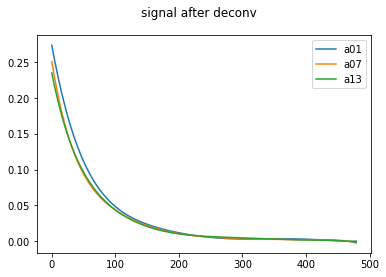

In [167]:
fig = plt.figure()
fig.suptitle('signal after deconv')
line3 = [None]*N
for i in range(N):
    line3[i], = plt.plot(h[i])
plt.legend([line3[0], line3[1],line3[2]], ['a01', 'a07','a13'])

plt.show()

In [208]:
class calculate_tao(object):
    
    def __init__(self, h, time_index):
        self.h = h
        self.time = time_index
        return None
    
    def fluo_decrease(self, I0,tao0,I1,tao1,t):
        i = I0*math.exp(-t/tao0) 
        + I1*math.exp(-t/tao1)
        return i
    
    
    def error_cal(self, x):
        I0= x[0]
        tao0 = x[1]
        I1 = x[2]
        tao1 = x[3]
        time = self.time*1e-9
        
        intensity1 = np.zeros((480, ), dtype = float)
        for i in range(time.shape[0] ):

            intensity1[i] = calculate_tao.fluo_decrease(self, I0,tao0,I1,tao1,time[i])
        
        self.intensity = intensity1
        
        return np.sum(abs(self.h-self.intensity))
#         return time
        
    def get_x(self):
        return self.intensity

In [212]:
rr = calculate_tao(h[2], time_index)
minimize(rr.error_cal, x0 = [0.25, 1e-8,0.25,1e-8], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True})

 final_simplex: (array([[2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08],
       [2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08],
       [2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08],
       [2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08],
       [2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08]]), array([0.92656082, 0.92656082, 0.92656082, 0.92656082, 0.92656082]))
           fun: 0.9265608238870293
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 802
           nit: 335
        status: 1
       success: False
             x: array([2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08])

In [213]:
para = np.zeros((N,4))
m = [None]*N
for i in range(N):
    m[i] = calculate_tao(h[i],time_index)
    para[i] = minimize(m[i].error_cal, x0 = [0.25, 1e-8,0.25,1e-8], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True}).x

Optimization terminated successfully.
         Current function value: 0.980113
         Iterations: 268
         Function evaluations: 581
Optimization terminated successfully.
         Current function value: 1.268119
         Iterations: 276
         Function evaluations: 556


In [214]:
para

array([[2.69725470e-01, 6.53766773e-09, 2.59395554e-01, 1.12907600e-08],
       [2.22978692e-01, 6.95634316e-09, 2.57513872e-01, 1.12435097e-08],
       [2.23317262e-01, 6.86789164e-09, 2.64919673e-01, 1.14881009e-08]])

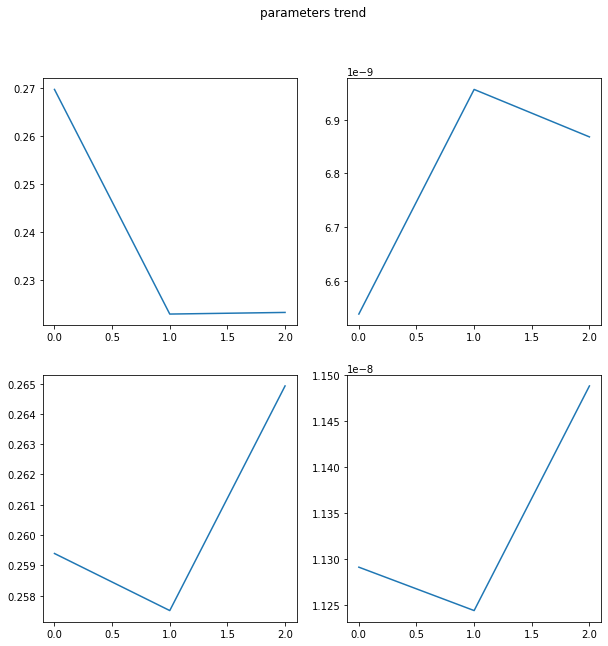

In [216]:
fig = plt.figure(figsize = (10,10))
fig.suptitle('parameters trend')
line = [None]*N
for j in range(4):
    plt.subplot(2,2,j+1)
    line[i], = plt.plot(para[:,j])
        
plt.show()